# CAI Lab Session 3: Programming with Elastic Search

In this session you will:

- Learn how to tell ElasticSearch to apply different tokenizers and filters to the documents, like removing stopwords or stemming the words.
- Study how these changes affect the terms that ElasticSearch puts in the index, and how this in turn affects searches.
- Complete a program to display documents in the tf-idf vector model.
- Compute document similarities with the cosine measure.


## 1. Preprocessing with ElasticSearch

One of the tasks of the previous session was to remove from the documents vocabulary all those strings that were not proper words. Obviously this is a frequent task and all these kinds of DB have standard processes that help to filter and reduce the terms that are not useful for searching.

Text, before being indexed, can be subjected to a pipeline of different processes that strips it from anything that will not be useful for a specific application. In ES these preprocessing pipelines are called _Analyzers_; ES includes many choices for each preprocessing step. 


The [following picture](https://www.elastic.co/es/blog/found-text-analysis-part-1) illustrates the chaining of preprocessing steps:

![](https://api.contentstack.io/v2/assets/575e4c8c3dc542cb38c08267/download?uid=blt51e787daed39eae9?uid=blt51e787daed39eae9)

The first step of the pipeline is usually a process that converts _raw text_ into _tokens_. We can for example tokenize a text using blanks and punctuation signs or use a language specific analyzer that detects words in an specific language or parse HTML/XML...

[This section](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-tokenizers.html) of the ElasticSearch manual explains the different text tokenizers available.

Once we have obtained tokens, we can _normalize_ the strings and/or filter out valid tokens that are not useful. For instance, strings can be transformed to lowercase so all occurrences of the same word are mapped to the same token regardless of whether they were capitalized. Also, there are words that are not semantically useful when searching such as adverbs, articles or prepositions, in this case each language will have its own standard list of words; these are usually called "_stopwords_". Another language-specific token normalization is stemming. The stem of a word corresponds to the common part of a word from all variants are formed by inflection or addition of suffixes or prefixes. For instance, the words "unstoppable", "stops" and "stopping" all derive from the stem "stop". The idea is that all variations of a word will be represented by the same token.

[This section](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-tokenfilters.html) of ElasticSearch manual will give you an idea of the possibilities.


## 2. Modifying `ElasticSearch` index behavior (using Analyzers)

In this section we are going to learn how to set up preprocessing with ElasticSearch. We are going to do it _inline_ so that you have a few examples and get familiar with how to set up ES analyzers. We are going to showcase the different options with the toy English phrase

```
my taylor 4ís was% &printing printed rich the.
```

which contains symbols and weird things to see what effect the different tokenizers and filtering options have. We are going to work with three of the usual processes:

* Tokenization
* Normalization
* Token filtering (stopwords and stemming)

The next cells allow configuring the default tokenizer for an index and analyze an example text. We are going to play a little bit with the possibilities and see what tokens result from the analysis.


In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Index, analyzer, tokenizer
from elasticsearch.exceptions import NotFoundError


client = Elasticsearch(timeout=1000)

### Token `whitespace` filter `lowercase`:

In [2]:
# Index analyzer cofiguration
# Change the configuration and run this cell and the next to see the changes

# Tokenizers: whitespace, standard, classic, letter
# Filters: lowercase, asciifolding, stop, porter_stem, kstem, snowball
my_analyzer = analyzer('default',
    type='custom',
    tokenizer=tokenizer('whitespace'), #all simbols separated with space
    filter=['lowercase']
)

# work with dummy index called 'foo'
ind = Index('foo', using=client)
ind.settings(number_of_shards=1)
# Shards are basically used to parallelize work on an index. When you send a bulk request to index 
# a list of documents, they will be split and divided among all available primary shards.
try:
    # drop if exists
    ind.delete()
except NotFoundError:
    pass

# create it
ind.create()

# close to update analyzer to custom `my_analyzer`    
ind.close()
ind.analyzer(my_analyzer)    
ind.save()
ind.open()

/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: the default value for the ?wait_for_active_shards parameter will change from '0' to 'index-setting' in version 8; specify '?wait_for_active_shards=index-setting' to adopt the future default behaviour, or '?wait_for_active_shards=0' to preserve today's behaviour
  warnings.warn(message, category=ElasticsearchWarning)


{'acknowledged': True, 'shards_acknowledged': True}

Now you can ask the index to analyze any text, feel free to change the text

In [3]:
res = ind.analyze(body={'analyzer':'default', 'text':u'my Taylor 4ís was% &printing printed rich the.'})
for r in res['tokens']:
    print(r)

{'token': 'my', 'start_offset': 0, 'end_offset': 2, 'type': 'word', 'position': 0}
{'token': 'taylor', 'start_offset': 3, 'end_offset': 9, 'type': 'word', 'position': 1}
{'token': '4ís', 'start_offset': 10, 'end_offset': 13, 'type': 'word', 'position': 2}
{'token': 'was%', 'start_offset': 14, 'end_offset': 18, 'type': 'word', 'position': 3}
{'token': '&printing', 'start_offset': 19, 'end_offset': 28, 'type': 'word', 'position': 4}
{'token': 'printed', 'start_offset': 29, 'end_offset': 36, 'type': 'word', 'position': 5}
{'token': 'rich', 'start_offset': 37, 'end_offset': 41, 'type': 'word', 'position': 6}
{'token': 'the.', 'start_offset': 42, 'end_offset': 46, 'type': 'word', 'position': 7}


### Token `standard` filter `lowercase`:

In [4]:
# Index analyzer cofiguration
# Change the configuration and run this cell and the next to see the changes

# Tokenizers: whitespace, standard, classic, letter
# Filters: lowercase, asciifolding, stop, porter_stem, kstem, snowball
my_analyzer = analyzer('default',
    type='custom',
    tokenizer=tokenizer('standard'), #not symbols
    filter=['lowercase']
)
   
ind = Index('foo', using=client)
ind.close()
ind.analyzer(my_analyzer)    
ind.save()
ind.open()

{'acknowledged': True, 'shards_acknowledged': True}

Now you can ask the index to analyze any text, feel free to change the text

In [5]:
res = ind.analyze(body={'analyzer':'default', 'text':u'my taylor 4ís was% &printing printed rich the.'})
for r in res['tokens']:
    print(r)

{'token': 'my', 'start_offset': 0, 'end_offset': 2, 'type': '<ALPHANUM>', 'position': 0}
{'token': 'taylor', 'start_offset': 3, 'end_offset': 9, 'type': '<ALPHANUM>', 'position': 1}
{'token': '4ís', 'start_offset': 10, 'end_offset': 13, 'type': '<ALPHANUM>', 'position': 2}
{'token': 'was', 'start_offset': 14, 'end_offset': 17, 'type': '<ALPHANUM>', 'position': 3}
{'token': 'printing', 'start_offset': 20, 'end_offset': 28, 'type': '<ALPHANUM>', 'position': 4}
{'token': 'printed', 'start_offset': 29, 'end_offset': 36, 'type': '<ALPHANUM>', 'position': 5}
{'token': 'rich', 'start_offset': 37, 'end_offset': 41, 'type': '<ALPHANUM>', 'position': 6}
{'token': 'the', 'start_offset': 42, 'end_offset': 45, 'type': '<ALPHANUM>', 'position': 7}


### Token `letter` filter `lowercase`:

In [6]:
# Index analyzer cofiguration
# Change the configuration and run this cell and the next to see the changes

# Tokenizers: whitespace, standard, classic, letter
# Filters: lowercase, asciifolding, stop, porter_stem, kstem, snowball
my_analyzer = analyzer('default',
    type='custom',
    tokenizer=tokenizer('letter'), # not number nor symbols
    filter=['lowercase']
)
   
ind = Index('foo', using=client)
ind.close()
ind.analyzer(my_analyzer)    
ind.save()
ind.open()

{'acknowledged': True, 'shards_acknowledged': True}

Now you can ask the index to analyze any text, feel free to change the text

In [7]:
res = ind.analyze(body={'analyzer':'default', 'text':u'my taylor 4ís was% &printing printed rich the.'})
for r in res['tokens']:
    print(r)

{'token': 'my', 'start_offset': 0, 'end_offset': 2, 'type': 'word', 'position': 0}
{'token': 'taylor', 'start_offset': 3, 'end_offset': 9, 'type': 'word', 'position': 1}
{'token': 'ís', 'start_offset': 11, 'end_offset': 13, 'type': 'word', 'position': 2}
{'token': 'was', 'start_offset': 14, 'end_offset': 17, 'type': 'word', 'position': 3}
{'token': 'printing', 'start_offset': 20, 'end_offset': 28, 'type': 'word', 'position': 4}
{'token': 'printed', 'start_offset': 29, 'end_offset': 36, 'type': 'word', 'position': 5}
{'token': 'rich', 'start_offset': 37, 'end_offset': 41, 'type': 'word', 'position': 6}
{'token': 'the', 'start_offset': 42, 'end_offset': 45, 'type': 'word', 'position': 7}


### Filter `asciifolding`

In [8]:
# Index analyzer cofiguration
# Change the configuration and run this cell and the next to see the changes

# Tokenizers: whitespace, standard, classic, letter
# Filters: lowercase, asciifolding, stop, porter_stem, kstem, snowball
my_analyzer = analyzer('default',
    type='custom',
    tokenizer=tokenizer('letter'),
    filter=['lowercase','asciifolding'] #delete accents
)
   
ind = Index('foo', using=client)
ind.close()
ind.analyzer(my_analyzer)    
ind.save()
ind.open()

{'acknowledged': True, 'shards_acknowledged': True}

Now you can ask the index to analyze any text, feel free to change the text

In [9]:
res = ind.analyze(body={'analyzer':'default', 'text':u'my taylor 4ís was% &printing printed rich the.'})
for r in res['tokens']:
    print(r)

{'token': 'my', 'start_offset': 0, 'end_offset': 2, 'type': 'word', 'position': 0}
{'token': 'taylor', 'start_offset': 3, 'end_offset': 9, 'type': 'word', 'position': 1}
{'token': 'is', 'start_offset': 11, 'end_offset': 13, 'type': 'word', 'position': 2}
{'token': 'was', 'start_offset': 14, 'end_offset': 17, 'type': 'word', 'position': 3}
{'token': 'printing', 'start_offset': 20, 'end_offset': 28, 'type': 'word', 'position': 4}
{'token': 'printed', 'start_offset': 29, 'end_offset': 36, 'type': 'word', 'position': 5}
{'token': 'rich', 'start_offset': 37, 'end_offset': 41, 'type': 'word', 'position': 6}
{'token': 'the', 'start_offset': 42, 'end_offset': 45, 'type': 'word', 'position': 7}


### Filter `asciifolding` + `stop`

In [10]:
# Index analyzer cofiguration
# Change the configuration and run this cell and the next to see the changes

# Tokenizers: whitespace, standard, classic, letter
# Filters: lowercase, asciifolding, stop, porter_stem, kstem, snowball
my_analyzer = analyzer('default',
    type='custom',
    tokenizer=tokenizer('letter'),
    filter=['lowercase','asciifolding', 'stop'] # only relevant words
)
   
ind = Index('foo', using=client)
ind.close()
ind.analyzer(my_analyzer)    
ind.save()
ind.open()

{'acknowledged': True, 'shards_acknowledged': True}

Now you can ask the index to analyze any text, feel free to change the text

In [11]:
res = ind.analyze(body={'analyzer':'default', 'text':u'my taylor 4ís was% &printing printed rich the.'})
for r in res['tokens']:
    print(r)

{'token': 'my', 'start_offset': 0, 'end_offset': 2, 'type': 'word', 'position': 0}
{'token': 'taylor', 'start_offset': 3, 'end_offset': 9, 'type': 'word', 'position': 1}
{'token': 'printing', 'start_offset': 20, 'end_offset': 28, 'type': 'word', 'position': 4}
{'token': 'printed', 'start_offset': 29, 'end_offset': 36, 'type': 'word', 'position': 5}
{'token': 'rich', 'start_offset': 37, 'end_offset': 41, 'type': 'word', 'position': 6}


### Filter `asciifolding` + `stop` + `snowball`

In [12]:
# Index analyzer cofiguration
# Change the configuration and run this cell and the next to see the changes

# Tokenizers: whitespace, standard, classic, letter
# Filters: lowercase, asciifolding, stop, porter_stem, kstem, snowball
my_analyzer = analyzer('default',
    type='custom',
    tokenizer=tokenizer('letter'),
    filter=['lowercase','asciifolding','stop', 'snowball'] # snowball is stemming, erasing derivations
)
   
ind = Index('foo', using=client)
ind.close()
ind.analyzer(my_analyzer)    
ind.save()
ind.open()

{'acknowledged': True, 'shards_acknowledged': True}

Now you can ask the index to analyze any text, feel free to change the text

In [13]:
res = ind.analyze(body={'analyzer':'default', 'text':u'my taylor 4ís was% &printing printed rich the.'})
for r in res['tokens']:
    print(r)

{'token': 'my', 'start_offset': 0, 'end_offset': 2, 'type': 'word', 'position': 0}
{'token': 'taylor', 'start_offset': 3, 'end_offset': 9, 'type': 'word', 'position': 1}
{'token': 'print', 'start_offset': 20, 'end_offset': 28, 'type': 'word', 'position': 4}
{'token': 'print', 'start_offset': 29, 'end_offset': 36, 'type': 'word', 'position': 5}
{'token': 'rich', 'start_offset': 37, 'end_offset': 41, 'type': 'word', 'position': 6}


---

**Exercise 1:** solve exercise 1 from problem set 1** using ElasticSearch.

---

In [14]:
my_analyzer = analyzer('default',
    type='custom',
    tokenizer=tokenizer('letter'),
    filter=['stop', 'kstem'] # snowball is stemming, erasing derivations
)
   
ind = Index('foo', using=client)
ind.close()
ind.analyzer(my_analyzer)    
ind.save()
ind.open()

res = ind.analyze(body={'analyzer':'default', 'text':u'We found my lady with no light in the room but the reading-lamp. The shade was screwed down so as to over-shadow her face. Instead of looking up at us in her usual straightforward way, she sat close at the table, and kept her eyes fixed obstinately on an open book. “Officer,” she said, “it is important to the inquiry you are conducting to know beforehand if any person now in this house wishes to leave it?”'})
# cleanup...
for r in res['tokens']:
    print(r)
ind.delete()

{'token': 'We', 'start_offset': 0, 'end_offset': 2, 'type': 'word', 'position': 0}
{'token': 'found', 'start_offset': 3, 'end_offset': 8, 'type': 'word', 'position': 1}
{'token': 'my', 'start_offset': 9, 'end_offset': 11, 'type': 'word', 'position': 2}
{'token': 'lady', 'start_offset': 12, 'end_offset': 16, 'type': 'word', 'position': 3}
{'token': 'light', 'start_offset': 25, 'end_offset': 30, 'type': 'word', 'position': 6}
{'token': 'room', 'start_offset': 38, 'end_offset': 42, 'type': 'word', 'position': 9}
{'token': 'reading', 'start_offset': 51, 'end_offset': 58, 'type': 'word', 'position': 12}
{'token': 'lamp', 'start_offset': 59, 'end_offset': 63, 'type': 'word', 'position': 13}
{'token': 'The', 'start_offset': 65, 'end_offset': 68, 'type': 'word', 'position': 14}
{'token': 'shade', 'start_offset': 69, 'end_offset': 74, 'type': 'word', 'position': 15}
{'token': 'screw', 'start_offset': 79, 'end_offset': 86, 'type': 'word', 'position': 17}
{'token': 'down', 'start_offset': 87, 'en

{'acknowledged': True}

## 3. The index reloaded

The first task of this session is to study how the preprocessing pipeline changes how tokens are produced. You have a new version of last session’s indexer script named `IndexFilesPreprocess.py`.

This new script has two additional flags `--token` and `--filter`.
The flag `--token` changes the text tokenizer, and you have four options: `whitespace`, `classic`, `standard` and `letter`. 

---

**Exercise 2:** Use each one of them with the novels documents and compare the results. Do not change the filter that is used by default (in this case only lowercasing the string). Have a look into the documentation to understand what these tokenizers do. Use the `CountWords.py` script from last session to see how many tokens are obtained.

After this, use the more aggressive tokenizer and use the filters available in the script: `lowercase` (obvious), `asciifolding` (gets rid of strange non ASCII characters that some languages love to use), `stop` (remove standard english stopwords) and the different stemming algorithms for the english language (`snowball`, `porter_stem` and `kstem`). You have to use the `--filter` flag, that must be the last one and you can put the filters to use separated by blank spaces, for instance:

```
$ python IndexFilesPreprocess.py --index news --path 20_newsgroups --token letter --filter lowercase asciifolding
```

Now you can answer the question, what word is the most frequent one in the English language (excluding stopwords)? (you will be surprised, or not, if you do this with the arxiv corpus)
As a bonus, you can learn how to configure the text analyzer of an index and you can change the script so more options can be used.

---

In [15]:
!python IndexFilesPreprocess.py --index nov --path novels --token letter --filter lowercase asciifolding
!python CountWords.py --index nov > novel_letter.csv
!python IndexFilesPreprocess.py --index nov --path novels --token whitespace --filter lowercase asciifolding
!python CountWords.py --index nov > novel_whitespace.csv
!python IndexFilesPreprocess.py --index nov --path novels --token classic --filter lowercase asciifolding
!python CountWords.py --index nov > novel_classic.csv
!python IndexFilesPreprocess.py --index nov --path novels --token standard --filter lowercase asciifolding
!python CountWords.py --index nov > novel_standard.csv

Indexing 33 files
Reading files ...
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: the default value for the ?wait_for_active_shards parameter will change from '0' to 'index-setting' in version 8; specify '?wait_for_active_shards=index-setting' to adopt the future default behaviour, or '?wait_for_active_shards=0' to preserve today's behaviour
  warnings.warn(message, category=ElasticsearchWarning)
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Using in

In [16]:
import csv
with open('/home/valeria/Dades/Tercer/CAI/lab3/novel_letter.csv','r', encoding='utf-8') as df:
    reader = csv.reader(df)
    data = list(reader)

print ("The tokenizer letter has:",data[-1][0])

with open('/home/valeria/Dades/Tercer/CAI/lab3/novel_whitespace.csv','r', encoding='utf-8') as df:
    reader = csv.reader(df)
    data = list(reader)

print ("The tokenizer whitespace has:",data[-1][0])

with open('/home/valeria/Dades/Tercer/CAI/lab3/novel_classic.csv','r', encoding='utf-8') as df:
    reader = csv.reader(df)
    data = list(reader)

print ("The tokenizer classic has:",data[-1][0])

with open('/home/valeria/Dades/Tercer/CAI/lab3/novel_standard.csv','r', encoding='utf-8') as df:
    reader = csv.reader(df)
    data = list(reader)

print ("The tokenizer standard has:",data[-1][0])

The tokenizer letter has: 31859 Words
The tokenizer whitespace has: 109723 Words
The tokenizer classic has: 47322 Words
The tokenizer standard has: 48495 Words


In [17]:
!python IndexFilesPreprocess.py --index novels1 --path novels --token standard --filter lowercase asciifolding stop kstem
!python CountWords.py --index novels1 > novels_filt.csv

Indexing 33 files
Reading files ...
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: the default value for the ?wait_for_active_shards parameter will change from '0' to 'index-setting' in version 8; specify '?wait_for_active_shards=index-setting' to adopt the future default behaviour, or '?wait_for_active_shards=0' to preserve today's behaviour
  warnings.warn(message, category=ElasticsearchWarning)
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Using in

I is the most frequent word. 

In [18]:
import csv
with open('/home/valeria/Dades/Tercer/CAI/lab3/novels_filt.csv','r') as df:
    reader = csv.reader(df)
    data = list(reader)

for word_rep in data[0:10]:
    print ("The word",word_rep[1],"has:\t",word_rep[0], "repetitions")

The word  i has:	 14394 repetitions
The word  his has:	 12980 repetitions
The word  he has:	 11735 repetitions
The word  had has:	 9742 repetitions
The word  which has:	 9107 repetitions
The word  from has:	 7432 repetitions
The word  have has:	 6707 repetitions
The word  were has:	 6222 repetitions
The word  all has:	 5896 repetitions
The word  we has:	 5851 repetitions


Letter - breaks text into terms whenever it encounters a character which is not a letter
Whitespace - breaks text into terms whenever it encounters a whitespace character.
Classic - grammar based tokenizer that is good for English language documents. This tokenizer has heuristics for special treatment of acronyms, company names, email addresses, and internet host names (works for English)
Standard -  provides grammar based tokenization (based on the Unicode Text Segmentation algorithm, as specified in Unicode Standard Annex #29) and works well for most languages

In [19]:
import matplotlib.pyplot as plt

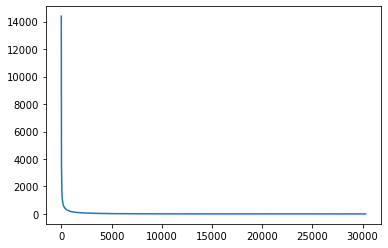

In [20]:
words = []
total = 0
final = False

with open("/home/valeria/Dades/Tercer/CAI/lab3/novels_filt.csv", "r") as df:
    for line in df:
        line = line.rstrip()

        if (line == "--------------------"):
            final = True
        else:
            if (final):
                lista = line.split(" ")
                total=int(lista[0])
            else:
                lista = line.split(",")
                words.append(int(lista[0]))
plt.plot(words)

## 4.  Computing Tf-Idf and Cosine similarity

This part of the session is to make sure we understand the tf-idf weight scheme for representing documents as vectors and the cosine similarity measure. We will complete a script that receives the paths of two files, obtains its ids from the index, computes the tf-idf vectors for the corresponding documents, optionally prints the vectors and finally computes their cosine similarity.

The script `TFIDFViewer.py` has a set of incomplete functions to achieve this:

- The main program follows the schema just explained

- The `search_file_by_path` function returns the id of a document in the index (the path has to be the exact full path where the documents were when indexed, not just a filename).

- The `document_term_vector` function returns two _lists of pairs_, the first one is (t, frequency of t in the document), the second one is (t, number of docs in the index that contain t). Both lists are alphabetically ordered by term.

- The incomplete `toTFIDF` function that returns a list of pairs (term, weight) representing the document with the given docid. It:
    1. First gets two lists with term document frequency and term index frequency.
    2. Gets the number of documents in the index.
    3. Then finally creates every pair (term, tf-idf) entry of the vector to be returned.
    
    Your task here is to complete the computations of the tf-idf value to fill this vector. You have all the ingredients ready, and you only have to apply the formulas explained in class.

- The incomplete `normalize` function should compute the norm of the vector (square root of the sums of components squared) and divide the whole vector by it, so that the resulting vector has norm (i.e. length) 1. Complete this function.

- The incomplete `print_term_weigth` vector prints one line for each entry in the given vector of the form (term, weight). Complete this function.

- The incomplete `cosine_similarity` function can be implemented by first normalizing both arguments (if they are not already), then computing their inner product. Complete this function. **IMPORTANT:** _It must be an efficient implementation, with at most one scan of each vector. Use strongly that the vectors are sorted by term alphabetically._

For computing the square root and log10 you can use the numpy library functions `log10` and `sqrt`. This library is already imported in the script as `np`.

---

**Exercise 3:** Complete all functions; test your implementation you have a set of documents inside the `doc` directory that correspond to the ones used in the theory slides examples.

---

In [21]:
!python IndexFilesPreprocess.py --index docs_index --path docs
!python TFIDFViewer.py --index docs_index --files docs/1 docs/2 > docs.csv

Indexing 7 files
Reading files ...
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: the default value for the ?wait_for_active_shards parameter will change from '0' to 'index-setting' in version 8; specify '?wait_for_active_shards=index-setting' to adopt the future default behaviour, or '?wait_for_active_shards=0' to preserve today's behaviour
  warnings.warn(message, category=ElasticsearchWarning)
/home/valeria/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Using inc

## 5. Experimenting

Once you are done with your program, try it out with the test collections from the previous sessions. First, test your implementation by computing the similarity of a file with itself (what should it give?).

You can do all sorts of experiments, for example, are the documents of a specific subset of the corpus `20_newgroups` more similar among them that to other unrelated subset (e.g `alt.atheism` vs. `sci-space`)? Explore and use your imagination.

A final question. Have you noticed that we are searching the documents using the _path name_? By default, all text fields are tokenized. Yet, if the path field had been tokenized, these searches would not succeed, right? So, what did we do differently when indexing the documents so that we can look for an exact match in the path field? Check the script.

---

**Exercise 4:** Explain what experimentation you have done, and whether the results you get make any sense. Finally, answer the question above.

---

## 6. Rules of delivery

- No plagiarism; don't discuss your work with other teams. You can ask for help to others for simple things, such as recalling a python instruction or module, but nothing too specific to the session. 

- If you feel you are spending much more time than the rest of the classmates, ask us for help. Questions can be asked either in person or by email, and you'll never be penalized by asking questions, no matter how stupid they look in retrospect.

- Write a short report with your results and thoughts. Make it at most 2 pages. Strive to summarize what new things you learned in this session. You are welcome to add conclusions and findings that depart from what we asked you to do.

- Turn the report to PDF. Make sure it has your names, date, and title. Create a single `.zip` file all the python scripts that you created or modified; in the modified scripts, make sure you mark visibly with comments the parts that you modified.

- Submit your work through the [raco](http://www.fib.upc.edu/en/serveis/raco.html). There will be a `Practica` open for each report.

- Deadline: Work must be delivered __within 2 weeks__ from the end of the lab session. Late submissions risk being penalized or not accepted at all. If you anticipate problems with the deadline, tell us as soon as possible.